In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy
import string

import matplotlib.pyplot as plt



use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(0)


file_name = "Frankenstein.txt"
# file_name = "Alice_In_Wonderland.txt"


print(f"Working on Device: {device}")

Working on Device: cuda


In [2]:
with open(file_name, 'r') as f:
    txt = f.read()

def preprocess(t):
    t = t.lower()
    t = " ".join(t.split())
    
    # remove punctuation and special characters
    for s in string.punctuation + "æèéêô—‘’“”ù":
        t = t.replace(s, "")
    return t

data = preprocess(txt)

In [3]:
print(sorted(set(data)))
print(f"Number of characters: {len(set(data))}")

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of characters: 37


Now lets create a dataset, here given a token $x_i$, we would like to predict what the token at $x_{i+1}$ should be. There is a very quick way of achieveing this, which is presented below in the `create_inp_out` function, where we offset the text.

In [4]:
def create_inp_out(data):
    inp = data[:-1]
    out = data[1:]
    return inp, out

The short example should meke it clear how it works as when we supply digit 1 we expect the model to output digit 2, when we supply 2 we expect the model to output digit 3, etc.

In [5]:
# short example
probe_data = "12345"
create_inp_out(probe_data)

('1234', '2345')

In [6]:
inp, target = create_inp_out(data)

Now, lets also convert our data to the vector representation. We are going to represent each character in one hot encoding format

In [7]:
# first we would have to create an integer representation of each character,
# and vice-versa
char2idx = {k: v for v, k in enumerate(sorted(set(data)))}
idx2char = {v: k for k, v in char2idx.items()}

vocab_size = len(char2idx)

print(char2idx)
print(idx2char)

{' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'x': 34, 'y': 35, 'z': 36}
{0: ' ', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'a', 12: 'b', 13: 'c', 14: 'd', 15: 'e', 16: 'f', 17: 'g', 18: 'h', 19: 'i', 20: 'j', 21: 'k', 22: 'l', 23: 'm', 24: 'n', 25: 'o', 26: 'p', 27: 'q', 28: 'r', 29: 's', 30: 't', 31: 'u', 32: 'v', 33: 'w', 34: 'x', 35: 'y', 36: 'z'}


In [8]:
def convert_to_one_hot(txt):
    res = [char2idx[ch] for ch in txt]
    res = torch.tensor(res)
    return torch.nn.functional.one_hot(res).type(torch.FloatTensor)

X = convert_to_one_hot(inp)
y = convert_to_one_hot(target)

In [9]:
# X.to(device).device

In [10]:
# Lets use Dataset functionality of PyTorch
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.X[index], self.y[index]


In [11]:
dataset = Dataset(X, y)

params = {'batch_size': 256,
          'shuffle': False,
          'num_workers': 6}

training_generator = torch.utils.data.DataLoader(dataset, **params)
print(f"Number of batches {len(training_generator)}")
# next(iter(training_generator))

Number of batches 1591


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_embedding = nn.Linear(vocab_size, 2).to(device)
        self.fc2 = nn.Linear(2, vocab_size).to(device)

    def forward(self, x):
        x = self.fc_embedding(x)
        # x = torch.tanh(x)
        x = F.softmax(self.fc2(x), dim=0)
        return x

In [13]:
NN = Net()
# NN(next(iter(training_generator))[0]).shape

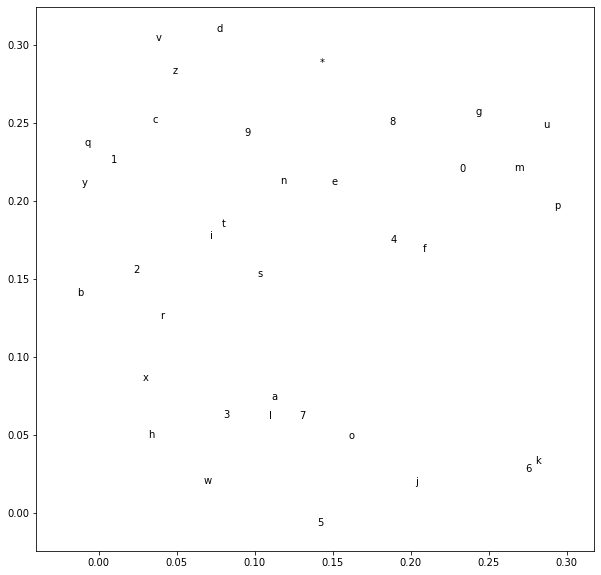

In [14]:
# First lets check what our `random` embeddings look like, before we even start 
# training

def plot_embeddings():
    plt.figure(figsize=(10,10))
    plt.axis("equal")
    res = NN.fc_embedding(torch.eye(vocab_size).to(device))
    res = res.cpu().detach().numpy()

    plt.scatter(res[:, 0], res[:, 1], c='white')
    for idx, char in idx2char.items():
        if char == " ":
            char = "*"
        plt.text(res[idx, 0], res[idx, 1], char)
    plt.show()


plot_embeddings()

In [15]:
import time
def train(model, lr=0.001, epochs=10):
    loss_criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for e in range(epochs):
        # if e+1 % 5 == 0:
        print(f"Epoch: {e+1}")
        start_time = time.time()
        
        running_loss = 0
        for data in training_generator:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model.forward(inputs)
            loss = loss_criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Loss: {running_loss} \t time: {time.time()-start_time:.2f}\n")
    print("finished training")

In [16]:
train(NN, epochs=80, lr=0.001)

Epoch: 1
Loss: 42.43138078972697 	 time: 7.07

Epoch: 2
Loss: 42.173272443935275 	 time: 6.55

Epoch: 3
Loss: 42.110945565626025 	 time: 6.82

Epoch: 4
Loss: 42.08671661093831 	 time: 6.43

Epoch: 5
Loss: 42.054220551624894 	 time: 6.53

Epoch: 6
Loss: 42.02317681722343 	 time: 6.91

Epoch: 7
Loss: 41.99911051057279 	 time: 6.47

Epoch: 8
Loss: 41.984758188948035 	 time: 6.61

Epoch: 9
Loss: 41.96374502405524 	 time: 6.79

Epoch: 10
Loss: 41.94576580636203 	 time: 6.41

Epoch: 11
Loss: 41.93746614269912 	 time: 6.46

Epoch: 12
Loss: 41.93195636384189 	 time: 6.73

Epoch: 13
Loss: 41.927505319938064 	 time: 6.66

Epoch: 14
Loss: 41.923389529809356 	 time: 6.45

Epoch: 15
Loss: 41.91869434714317 	 time: 6.58

Epoch: 16
Loss: 41.91289408132434 	 time: 6.59

Epoch: 17
Loss: 41.90773310698569 	 time: 6.94

Epoch: 18
Loss: 41.904046945273876 	 time: 6.53

Epoch: 19
Loss: 41.901286540552974 	 time: 6.39

Epoch: 20
Loss: 41.89908911846578 	 time: 6.73

Epoch: 21
Loss: 41.89729241654277 	 time:

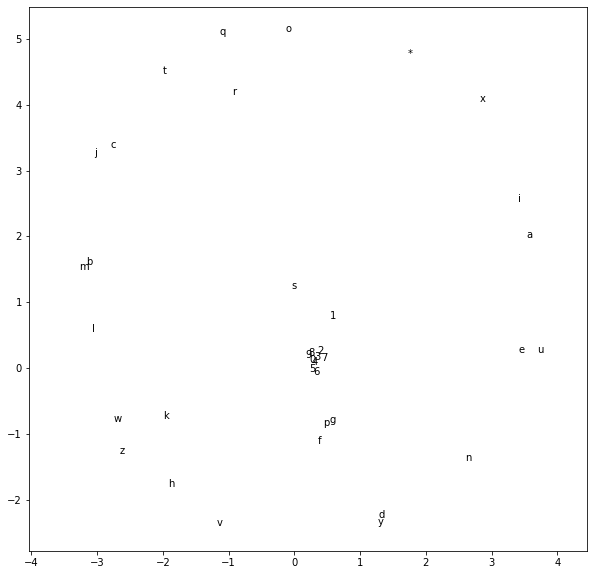

In [17]:
plot_embeddings()